# Visualize and Evaluate model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib
import argparse
import os
from os.path import isfile,join
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import sys
sys.path.insert(1, '../utils')
sys.path.insert(1, '../datasets')
sys.path.insert(1, '../search')
import coco_utils as cu
import my_datasets as mdset
import eval_train as ev
import utils as U
import find_best_model as fbm
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap




## Parameters

In [3]:
# DATASETS
dataroot_voc = '/share/DEEPLEARNING/datasets/voc2012'
dataroot_sbd = '/share/DEEPLEARNING/datasets/sbd'
dataroot_coco = '/share/DEEPLEARNING/datasets/coco'
dataroot_landcover = '/share/DEEPLEARNING/datasets/landcover'
dataroot_coco2voc = '/users/k/karmimy/data/coco2voc'
VOC = True

nw = 4 
pm = True
#MODEL SAVE AND LOAD 
load_dir = '/share/homes/karmimy/equiv/save_model' # Saved model dir
#exp = 'rot_equiv_lc' # Exp dir
exp = 'rot_equiv' 
#model_name = 'rot_equiv_lc.pt' # saved model name
model_name = 'equiv_dlv3.pt'
folder_model = join(load_dir,exp,'92') 
#fcn= True
#pretrained=True

# GPU 
gpu = 0
# EVAL PARAMETERS
bs = 1 

# LOSS 
criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.
Loss = 'KL' # Loss = 'KL' or 'CE' or None for L1,MSE…
criterion_unsupervised = U.get_criterion(Loss)


# DEVICE
# Decide which device we want to run on
device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
print("device :",device)

device : cuda:0


In [4]:
model = torch.load(join(folder_model,model_name),map_location=device)


## DATASETS

In [5]:
if VOC :
        num_classes = 21
        test_dataset = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=False)
        
else:
        num_classes = 4
        print('Loading Landscape Dataset')
        train_dataset = mdset.LandscapeDataset(dataroot_landcover,image_set="trainval",\
            rotate=rotate)#,size_img=size_img,size_crop=size_crop)
        test_dataset = mdset.LandscapeDataset(dataroot_landcover,image_set="test")
        test_dataset_no_norm =  mdset.LandscapeDataset(dataroot_landcover,image_set="test",normalize=False)
        print('Success load Landscape Dataset')

dataloader_val = torch.utils.data.DataLoader(test_dataset,num_workers=nw,pin_memory=pm,\
        batch_size=bs)

## SHOW MODEL PREDICTIONS

In [20]:
# PARAMETERS FOR THE VISUALIZATION 
NUMBER_EXAMPLES = 2
list_iter = np.random.randint(0,len(test_dataset),NUMBER_EXAMPLES) # TAKE N RANDOM IMAGES 
list_iter = np.arange(73,73+NUMBER_EXAMPLES)

angle_fix = 0
test_dataset = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=False,fixing_rotate=True,angle_fix=angle_fix)
test_dataset_no_norm = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', normalize=False,download=False,fixing_rotate=True,angle_fix=angle_fix)
dataloader_val = torch.utils.data.DataLoader(test_dataset,num_workers=nw,pin_memory=pm,batch_size=bs)

CMAP_voc = U.color_map(normalized=True)
CMAP = U.get_cmap()


cmap = ListedColormap(CMAP_voc)



ITERATION 73 / 2
ITERATION 74 / 2
/users/k/karmimy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


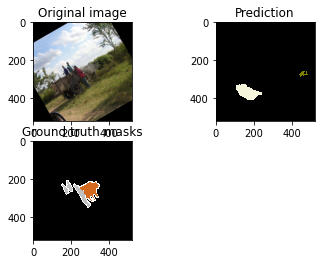

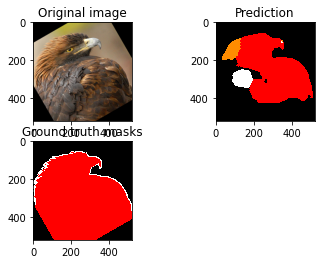

In [12]:
model = torch.load('/share/homes/karmimy/equiv/save_model/fully_supervised/18/fcn_fully_sup.pt',map_location=device)
for i in list_iter:
    print('ITERATION',i,'/',NUMBER_EXAMPLES)
    im,m = test_dataset_no_norm.__getitem__(i)
    x = im.unsqueeze(0).to(device)
    pred = model(x)
    pred = pred['out']
    pred = pred.argmax(dim=1).squeeze().cpu()
    im.transpose_(0,2)
    im.transpose_(0,1)
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.title.set_text('Original image')
    ax1.imshow(im.cpu())
    ax2 = fig.add_subplot(2,2,2)
    ax2.title.set_text('Prediction')
    ax2.imshow(pred,cmap=CMAP,vmin=0,vmax=22,interpolation='nearest')
    ax3 = fig.add_subplot(2,2,3)
    ax3.title.set_text('Ground truth masks')
    ax3.imshow(m.cpu(),cmap=CMAP,vmin=0,vmax=22,interpolation='nearest')
    




ITERATION 73 / 2
ITERATION 74 / 2


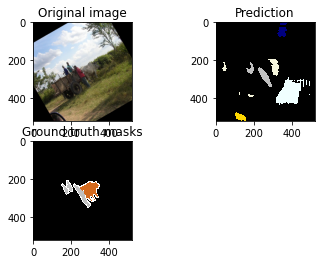

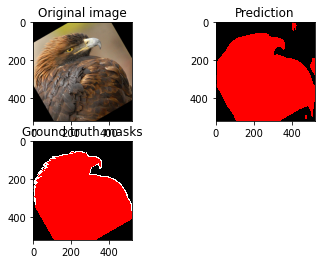

In [13]:
model = torch.load('/share/homes/karmimy/equiv/save_model/rot_equiv/92/equiv_dlv3.pt',map_location=device)

for i in list_iter:
    print('ITERATION',i,'/',NUMBER_EXAMPLES)
    im,m = test_dataset_no_norm.__getitem__(i)
    x = im.unsqueeze(0).to(device)
    pred = model(x)
    pred = pred['out']
    pred = pred.argmax(dim=1).squeeze().cpu()
    im.transpose_(0,2)
    im.transpose_(0,1)
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.title.set_text('Original image')
    ax1.imshow(im.cpu())
    ax2 = fig.add_subplot(2,2,2)
    ax2.title.set_text('Prediction')
    ax2.imshow(pred,cmap=CMAP,vmin=0,vmax=22,interpolation='nearest')
    ax3 = fig.add_subplot(2,2,3)
    ax3.title.set_text('Ground truth masks')
    ax3.imshow(m.cpu(),cmap=CMAP,vmin=0,vmax=22,interpolation='nearest')
    

ITERATION 73 / 2
ITERATION 74 / 2


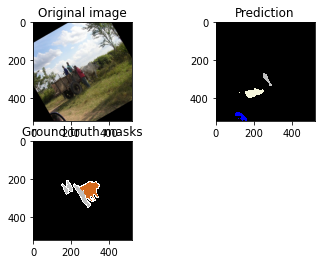

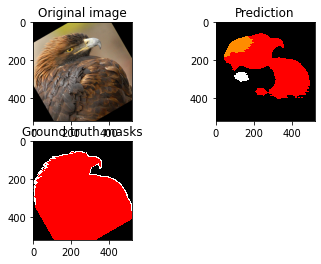

In [14]:
model = torch.load('/share/homes/karmimy/equiv/save_model/fully_supervised/17/fcn_fully_sup.pt',map_location=device)
for i in list_iter:
    print('ITERATION',i,'/',NUMBER_EXAMPLES)
    im,m = test_dataset_no_norm.__getitem__(i)
    x = im.unsqueeze(0).to(device)
    pred = model(x)
    pred = pred['out']
    pred = pred.argmax(dim=1).squeeze().cpu()
    im.transpose_(0,2)
    im.transpose_(0,1)
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.title.set_text('Original image')
    ax1.imshow(im.cpu())
    ax2 = fig.add_subplot(2,2,2)
    ax2.title.set_text('Prediction')
    ax2.imshow(pred,cmap=CMAP,vmin=0,vmax=22,interpolation='nearest')
    ax3 = fig.add_subplot(2,2,3)
    ax3.title.set_text('Ground truth masks')
    ax3.imshow(m.cpu(),cmap=CMAP,vmin=0,vmax=22,interpolation='nearest')

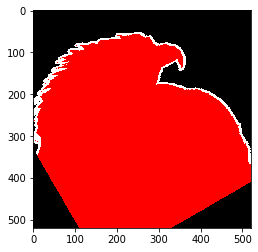

In [21]:
im,m =  test_dataset_no_norm.__getitem__(74)
plt.imshow(m,cmap=CMAP,vmin=0,vmax=22,interpolation='nearest')

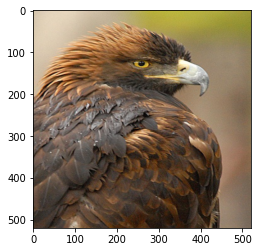

In [19]:
plt.imshow(im.transpose_(0,2).transpose(0,1))
